In [22]:
import subprocess as sub
import sys
import ads
import re
import json
import pandas as pd
import ogr
from matplotlib import pylab
from paper_class import Paper
from feature_class import Feature
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [23]:
# routine to read information from json file
# creates a Feature instance with extracted data
def feature_extract(obj):
    if '__type__' in obj and obj['__type__'] == 'Feature':
        return Feature(obj['name'], obj['id'], obj['polygon_coordinates'], obj['publications'])
    return Feature("None", 0, "None", "None")

In [24]:
# routine to parse json file and fetch definition of each feature
def parse_json_stream(text):
    list_idx = [m.start() for m in re.finditer('}\n', text)]
    list_objs = []
    last_index = 0
    for index in list_idx:
        new_feature = json.loads(text[last_index:index+2], object_hook=feature_extract)
        if (new_feature.name == "None"):
            break
        list_objs += [new_feature]
        last_index = index+2
    return list_objs

In [25]:
# code is taken from jupyter notebook 
# https://github.com/epn-vespa/vespamap17-hackathon/blob/master/vespa-mapping-jupyter-samp/SendName_to_IAUnomenclature_findPolygon_hacky.ipynb
def draw_feature_contour(feature):
    geomOGR = ogr.CreateGeometryFromWkt(feature.pcoord)
    
    figsize(6,6)
    
    coords = json.loads(geomOGR.ExportToJson())['coordinates'][0]
    x = [i for i,j in coords[0]]
    y = [j for i,j in coords[0]]

    plot(x, y, 'b')
    pylab.xlabel('Longitude')
    pylab.ylabel('Latitude')
    pylab.title('Feature : ' + feature.name)
    grid()

In [26]:
# To create a database with features and their topological structure
# One needs to create a csv file with 
# https://planetarynames.wr.usgs.gov/nomenclature/AdvancedSearch
# and pass it to the database_creation script
# IMPORTANT: feature ID and feature name should be present in csv file

In [27]:
script_name = "database_merged.py"
csv_file_name = "Mars_short.csv"
output_file_name = "features.json"
try:
    ret = sub.call(' '.join(["python", script_name, csv_file_name, output_file_name]), shell = True)
    if (ret != 0):
        print("Child returned", ret, file=sys.stderr)
except OSError as e:
    print("Execution failed: ", e, file=sys.stderr)

In [43]:
# now database is built and we want to provide speific queries to ADS
authors = ["Tanaka, K. L.", "Kolb, E. J.", "Fortezzo, C."]
toponym = "Abalos Colles"
years = range(2003, 2008)
query_list = ["", "", ""]

if (toponym):
    query_list[0] = toponym

if (authors):
    for idx in range(len(authors) - 1):
        query_list[1] += "author:" + authors[idx] + " OR "
    query_list[1] += "author:" + authors[-1]
        
if (years):
    query_list[2] = "year:[" + str(years.start) + " TO " + str(years.stop) + "]" 

query = ' AND '.join(filter(None, query_list))

In [44]:
if (not query):
    raise RuntimeError("Empty query is not allowed!")
print(query)

Abalos Colles AND author:Tanaka, K. L. OR author:Kolb, E. J. OR author:Fortezzo, C. AND year:[2003 TO 2008]


In [46]:
#performing a query to ADS API
example_results = []
try:
    example_results = list(ads.SearchQuery(q=query, fl=['title', 'author', 'year', 'pub', 'bibcode']))
except (ads.exceptions.APIResponseError, ads.exceptions.SolrResponseParseError) as e:
    "Error: {}".format(e)

In [47]:
# representing results with custom Paper class
results_new = []
for paper in example_results:
    results_new.append(Paper(paper.title[0], paper.author, paper.year, paper.pub, paper.bibcode))

In [48]:
# dig the database for the requested toponym
with open(output_file_name) as fin:
    features = parse_json_stream(fin.read())

Abalos Colles is found in the database!


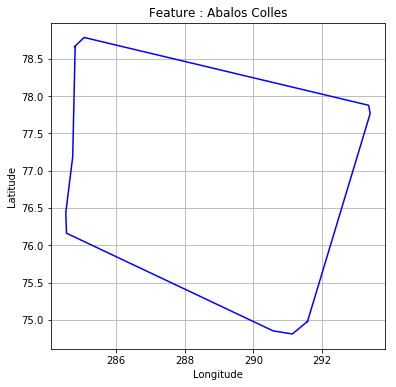

In [49]:
# if the entry exists - draw the toponym as a polygon
for feature in features:
    if (toponym == feature.name):
        print(toponym + " is found in the database!")
        draw_feature_contour(feature)
        break

In [50]:
# create pandas table
pd.set_option('display.max_colwidth', -1)
df = pd.DataFrame([paper.to_dict() for paper in results_new])

In [52]:
df

,authors,bibcode,publication,title,year
0,"[Tanaka, K. L., Kolb, E. J., Fortezzo, C.]",2007LPICo1353.3276T,Seventh International Conference on Mars,Recent Advances in the Stratigraphy of the Polar Regions of Mars,2007
1,"[Tanaka, Kenneth L., Rodriguez, J. Alexis P., Skinner, James A., Bourke, Mary C., Fortezzo, Corey M., Herkenhoff, Kenneth E., Kolb, Eric J., Okubo, Chris H.]",2008Icar..196..318T,Icarus,"North polar region of Mars: Advances in stratigraphy, structure, and erosional modification",2008
2,"[Tanaka, K. L., Mullins, K. F., Skinner, J. A., Jr., Rodriguez, J. A. P., Fortezzo, C. M.]",2006LPI....37.2344T,37th Annual Lunar and Planetary Science Conference,Stratigraphy of North Polar Deposits on Mars: Major New Findings,2006
3,"[Tanaka, K. L., Skinner, J. A., Hare, T. M., Joyal, T., Wenker, A.]",2003JGRE..108.8043T,Journal of Geophysical Research (Planets),Resurfacing history of the northern plains of Mars based on geologic mapping of Mars Global Surveyor data,2003
